# Image Colorization with U-Net and GAN Tutorial

**If you have already read the explanations, you can directly go to the code starting with heading: _1 - Implementing the paper - Our Baseline_**

In all papers I studied and all codes I checked out on colorization on GitHub, people use L\*a\*b color space instead of RGB to train the models. There are a couple of reasons for this choice but I'll give you an intuition of why we make this choice. To train a model for colorization, we should give it a grayscale image and hope that it will make it colorful. When using L\*a\*b, we can give the L channel to the model (which is the grayscale image) and want it to predict the other two channels (\*a, \*b) and after its prediction, we concatenate all the channels and we get our colorful image. But if you use RGB, you have to first convert your image to grayscale, feed the grayscale image to the model and hope it will predict 3 numbers for you which is a way more difficult and unstable task due to the many more possible combinations of 3 numbers compared to two numbers. If we assume we have 256 choices (in a 8-bit unsigned integer image this is the real number of choices) for each number, predicting the three numbers for each of the pixels is choosing between 256³ combinations which is more than 16 million choices, but when predicting two numbers we have about 65000 choices (actually, we are not going to wildly choose these numbers like a classification task and I just wrote these numbers to give you an intuition).

## How to solve the problem

During the last few years, many different solutions have been proposed to colorize images by using deep learning. [_**Colorful Image Colorization**_](https://arxiv.org/abs/1603.08511) paper approached the problem as a classification task and they also considered the uncertainty of this problem (e.x. a car in the image can take on many different and valid colors and we cannot be sure about any color for it); however, another paper approached the problem as a regression task (with some more tweaks!). There are pros and cons to each approach but in this article, we are going to use a different strategy.

### The strategy we are going to use

[_**Image-to-Image Translation with Conditional Adversarial Networks**_](https://arxiv.org/abs/1611.07004) paper, which you may know by the name pix2pix, proposed a general solution to many image-to-image tasks in deep learning which one of those was colorization. In this approach two losses are used: L1 loss, which makes it a regression task, and an adversarial (GAN) loss, which helps to solve the problem in an unsupervised manner (by assigning the outputs a number indicating how "real" they look!).

In this tutorial, I will first implement what the authors did in the paper and then I will introduce a whole new generator model and some tweaks in the strategy of training which significantly helps reduce the size of needed dataset while getting amazing results. So stay tuned :)

### A deeper dive into GAN world

As mentioned earlier, we are going to build a GAN (a conditional GAN to be specific) and use an extra loss function, L1 loss. Let's start with the GAN.

As you might know, in a GAN we have a generator and a discriminator model which learn to solve a problem together. In our setting, the generator model takes a grayscale image (1-channel image) and produces a 2-channel image, a channel for \*a and another for \*b. The discriminator, takes these two produced channels and concatenates them with the input grayscale image and decides whether this new 3-channel image is fake or real. Of course the discriminator also needs to see some real images (3-channel images again in Lab color space) that are not produced by the generator and should learn that they are real. 

So what about the "condition" we mentioned? Well, that grayscale image which both the generator and discriminator see is the condition that we provide to both models in our GAN and expect that the they take this condition into consideration.

Let's take a look at the math. Consider _**x**_ as the grayscale image, _**z**_ as the input noise for the generator, and _**y**_ as the 2-channel output we want from the generator (it can also represent the 2 color channels of a real image). Also, _**G**_ is the generator model and _**D**_ is the discriminator. Then the loss for our conditional GAN will be:

![GAN Loss](https://github.com/moein-shariatnia/Deep-Learning/blob/main/Image%20Colorization%20Tutorial/files/GAN_loss.jpg?raw=1)

Notice that _**x**_ is given to both models which is the condition we introduce two both players of this game. Actually, we are not going to feed a "n" dimensional vector of random noise to the generator as you might expect but the noise is introduced in the form of dropout layers (there is something cool about it which you will read in the last section of the article) in the generator architecture.

### Loss function we optimize

The earlier loss function helps to produce good-looking colorful images that seem real, but to further help the models and introduce some supervision in our task, we combine this loss function with L1 Loss (you might know L1 loss as mean absolute error) of the predicted colors compared with the actual colors:

![L1 loss](https://github.com/moein-shariatnia/Deep-Learning/blob/main/Image%20Colorization%20Tutorial/files/l1_loss.jpg?raw=1)

If we use L1 loss alone, the model still learns to colorize the images but it will be conservative and most of the time uses colors like "gray" or "brown" because when it doubts which color is the best, it takes the average and uses these colors to reduce the L1 loss as much as possible (it is similar to the blurring effect of L1 or L2 loss in super resolution task). Also, the L1 Loss is preferred over L2 loss (or mean squared error) because it reduces that effect of producing gray-ish images. So, our combined loss function will be:

![loss](https://github.com/moein-shariatnia/Deep-Learning/blob/main/Image%20Colorization%20Tutorial/files/loss.jpg?raw=1)

where _**λ**_ is a coefficient to balance the contribution of the two losses to the final loss (of course the discriminator loss does not involve the L1 loss).

Okay. I think it's enough for theory! Let's get our hands dirty with the code! In the following section, **I first introduce the code to implement the paper** and in the section after that, **I will introduce a better strategy to get really amazing results in one or two hours of training and without needing huge amount of data!**

## 1 - Implementing the paper - Our Baseline

### 1.1- Loading Image Paths

The paper uses the whole ImageNet dataset (with 1.3 million images!) but here I'm using only 8,000 images from COCO dataset for training which I had available on my device. So our training set size is 0.6% of what was used in the paper!
You can use almost any dataset for this task as far as it contains many different scenes and locations which you hope it will learn to colorize. You can use ImageNet for example but you will only need 8000 of its images for this project.

In [2]:
# import numpy as np
# import os
# import time
# # from vgg16 import VGG16
# from newvgg16 import VGG16
# from keras.preprocessing import image
# from keras.applications.imagenet_utils import preprocess_input
# from keras.applications.vgg16 import decode_predictions
# from keras.layers import Dense, Activation, Flatten
# from keras.layers import merge, Input
# from keras.models import Model
# from keras.utils import np_utils
# from sklearn.utils import shuffle
# from sklearn.model_selection import train_test_split
# from sagemaker import get_execution_role
# import s3fs
# from PIL import Image
# from tqdm import tqdm_notebook as tqdm
# import pickle
# from sagemaker import get_execution_role
# import s3fs
# import matplotlib.image as mpimg
# from PIL import Image
# import h5py
# import boto3
# import io

import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
from skimage import transform

import pkg_resources
# pkg_resources.require("torch==1.6")
import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_colab = None
import pickle

### 1.1.x Preparing Colab for running the code

If you are opening this on **Google Colab** you can uncomment and run the following to install fastai. Almost all of the code in the tutorial is with **pure PyTorch**. We need fastai here only to download part of COCO dataset and in one other step in the second section of the tutorial.

Also make sure to set your runtime to **GPU** to be able to train the models much faster.

In [3]:
!pip install fastai --upgrade

     |████████████████████████████████| 193 kB 25.1 MB/s eta 0:00:01
     |█████████████                   | 317.7 MB 170.9 MB/s eta 0:00:03    |███▋                            | 87.8 MB 110.1 MB/s eta 0:00:07

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 776.8 MB 160.6 MB/s eta 0:00:01     |████████████████████████████████| 776.8 MB 10 kB/s 
     |████████████████████████████████| 53 kB 401 kB/s s eta 0:00:01
     |████████████████████████████████| 10.4 MB 74.6 MB/s eta 0:00:01
     |████████████████████████████████| 12.8 MB 68.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 70.3 MB/s eta 0:00:01
     |████████████████████████████████| 126 kB 141.3 MB/s eta 0:00:01
     |████████████████████████████████| 184 kB 127.2 MB/s eta 0:00:01
     |████████████████████████████████| 9.8 MB 60.6 MB/s eta 0:00:01
  Attempting uninstall: torch
    Found existing installation: torch 1.5.1
    Uninstalling torch-1.5.1:
      Successfully uninstalled torch-1.5.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.6.1
    Uninstalling torchvision-0.6.1:
      Successfully uninstalled torchvision-0.6.1
ERROR: pip's dependency resolver does not currently take into ac

The following will download about 20,000 images from COCO dataset. Notice that **we are going to use only 8000 of them** for training. Also you can use any other dataset like ImageNet as long as it contains various scenes and locations.

In [4]:
# from fastai.data.external import untar_data, URLs
# coco_path = untar_data(URLs.COCO_SAMPLE)
# coco_path = str(coco_path) + "/train_sample"
# use_colab = False
from sagemaker import get_execution_role
import s3fs

[0, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 22, 23, 24, 25, 26, 27, 28, 29, 30, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 93, 94, 95, 96, 97, 98, 100, 101, 102, 103, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 164, 165, 166, 167, 171, 172, 173, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 206, 207, 208, 209, 210, 211, 212, 213, 214, 217, 218, 219, 220, 221, 222, 223, 224, 225, 228, 229, 233, 234, 235, 236, 237, 238, 239, 241, 242, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 266, 267, 268, 269, 270

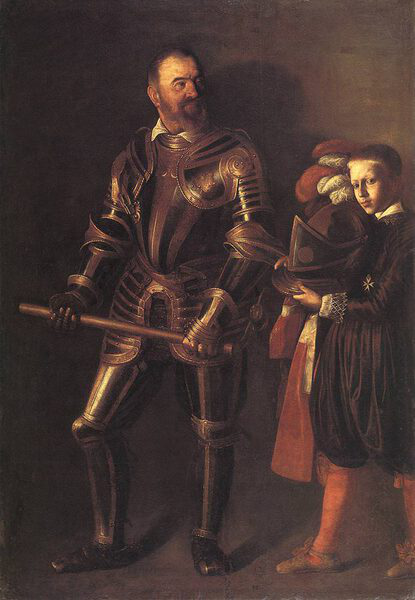

In [5]:
fs = s3fs.S3FileSystem()

directory = 's3://sagemaker-studio-sqsv4ommlw8/resized'
filenames = fs.ls(directory)
# print(filenames[0])

validArtists = ['Caravaggio', 'El_Greco', 'Eugene_Delacroix', 'Gustave_Courbet', 'Michelangelo', 'Peter_Paul_Rubens', 'Raphael', 'Rembrandt', 'Sandro_Botticelli', 'Titian']

train_images = [['Michelangelo_45.jpg', 'Michelangelo_44.jpg', 'Michelangelo_46.jpg', 'Michelangelo_47.jpg', 'Michelangelo_43.jpg', 'Michelangelo_42.jpg', 'Michelangelo_40.jpg', 'Michelangelo_9.jpg', 'Michelangelo_8.jpg', 'Michelangelo_41.jpg', 'Michelangelo_26.jpg', 'Michelangelo_32.jpg', 'Michelangelo_33.jpg', 'Michelangelo_27.jpg', 'Michelangelo_19.jpg', 'Michelangelo_31.jpg', 'Michelangelo_25.jpg', 'Michelangelo_24.jpg', 'Michelangelo_30.jpg', 'Michelangelo_18.jpg', 'Michelangelo_34.jpg', 'Michelangelo_20.jpg', 'Michelangelo_21.jpg', 'Michelangelo_35.jpg', 'Michelangelo_23.jpg', 'Michelangelo_37.jpg', 'Michelangelo_36.jpg', 'Michelangelo_22.jpg', 'Michelangelo_13.jpg', 'Michelangelo_12.jpg', 'Michelangelo_38.jpg', 'Michelangelo_10.jpg', 'Michelangelo_11.jpg', 'Michelangelo_39.jpg', 'Michelangelo_15.jpg', 'Michelangelo_29.jpg', 'Michelangelo_28.jpg', 'Michelangelo_14.jpg', 'Michelangelo_16.jpg'], ['Titian_232.jpg', 'Titian_226.jpg', 'Titian_144.jpg', 'Titian_91.jpg', 'Titian_85.jpg', 'Titian_150.jpg', 'Titian_178.jpg', 'Titian_187.jpg', 'Titian_52.jpg', 'Titian_46.jpg', 'Titian_193.jpg', 'Titian_47.jpg', 'Titian_192.jpg', 'Titian_186.jpg', 'Titian_53.jpg', 'Titian_179.jpg', 'Titian_84.jpg', 'Titian_151.jpg', 'Titian_145.jpg', 'Titian_90.jpg', 'Titian_227.jpg', 'Titian_233.jpg', 'Titian_225.jpg', 'Titian_231.jpg', 'Titian_219.jpg', 'Titian_153.jpg', 'Titian_86.jpg', 'Titian_92.jpg', 'Titian_147.jpg', 'Titian_190.jpg', 'Titian_45.jpg', 'Titian_51.jpg', 'Titian_184.jpg', 'Titian_79.jpg', 'Titian_78.jpg', 'Titian_50.jpg', 'Titian_185.jpg', 'Titian_191.jpg', 'Titian_44.jpg', 'Titian_93.jpg', 'Titian_146.jpg', 'Titian_152.jpg', 'Titian_87.jpg', 'Titian_218.jpg', 'Titian_230.jpg', 'Titian_224.jpg', 'Titian_208.jpg', 'Titian_220.jpg', 'Titian_234.jpg', 'Titian_83.jpg', 'Titian_156.jpg', 'Titian_142.jpg', 'Titian_97.jpg', 'Titian_68.jpg', 'Titian_40.jpg', 'Titian_195.jpg', 'Titian_181.jpg', 'Titian_54.jpg', 'Titian_180.jpg', 'Titian_55.jpg', 'Titian_41.jpg', 'Titian_194.jpg', 'Titian_69.jpg', 'Titian_143.jpg', 'Titian_96.jpg', 'Titian_82.jpg', 'Titian_157.jpg', 'Titian_235.jpg', 'Titian_221.jpg', 'Titian_209.jpg', 'Titian_237.jpg', 'Titian_223.jpg', 'Titian_169.jpg', 'Titian_94.jpg', 'Titian_141.jpg', 'Titian_155.jpg', 'Titian_80.jpg', 'Titian_57.jpg', 'Titian_182.jpg', 'Titian_196.jpg', 'Titian_43.jpg', 'Titian_197.jpg', 'Titian_42.jpg', 'Titian_56.jpg', 'Titian_183.jpg', 'Titian_154.jpg', 'Titian_81.jpg', 'Titian_95.jpg', 'Titian_140.jpg', 'Titian_168.jpg', 'Titian_222.jpg', 'Titian_236.jpg', 'Titian_251.jpg', 'Titian_245.jpg', 'Titian_127.jpg', 'Titian_133.jpg', 'Titian_31.jpg', 'Titian_25.jpg', 'Titian_19.jpg', 'Titian_18.jpg', 'Titian_24.jpg', 'Titian_30.jpg', 'Titian_132.jpg', 'Titian_126.jpg', 'Titian_244.jpg', 'Titian_250.jpg', 'Titian_246.jpg', 'Titian_252.jpg', 'Titian_130.jpg', 'Titian_124.jpg', 'Titian_118.jpg', 'Titian_26.jpg', 'Titian_32.jpg', 'Titian_8.jpg', 'Titian_9.jpg', 'Titian_33.jpg', 'Titian_27.jpg', 'Titian_119.jpg', 'Titian_125.jpg', 'Titian_131.jpg', 'Titian_253.jpg', 'Titian_247.jpg', 'Titian_243.jpg', 'Titian_109.jpg', 'Titian_135.jpg', 'Titian_121.jpg', 'Titian_23.jpg', 'Titian_37.jpg', 'Titian_36.jpg', 'Titian_22.jpg', 'Titian_120.jpg', 'Titian_134.jpg', 'Titian_108.jpg', 'Titian_242.jpg', 'Titian_254.jpg', 'Titian_240.jpg', 'Titian_122.jpg', 'Titian_136.jpg', 'Titian_34.jpg', 'Titian_20.jpg', 'Titian_21.jpg', 'Titian_35.jpg', 'Titian_137.jpg', 'Titian_123.jpg', 'Titian_241.jpg', 'Titian_255.jpg', 'Titian_106.jpg', 'Titian_112.jpg', 'Titian_10.jpg', 'Titian_38.jpg', 'Titian_2.jpg', 'Titian_3.jpg', 'Titian_39.jpg', 'Titian_11.jpg', 'Titian_113.jpg', 'Titian_107.jpg', 'Titian_111.jpg', 'Titian_105.jpg', 'Titian_139.jpg', 'Titian_13.jpg', 'Titian_1.jpg', 'Titian_12.jpg', 'Titian_138.jpg', 'Titian_104.jpg', 'Titian_110.jpg', 'Titian_128.jpg', 'Titian_114.jpg', 'Titian_100.jpg', 'Titian_16.jpg', 'Titian_4.jpg', 'Titian_5.jpg', 'Titian_17.jpg', 'Titian_101.jpg', 'Titian_115.jpg', 'Titian_129.jpg', 'Titian_249.jpg', 'Titian_103.jpg', 'Titian_117.jpg', 'Titian_29.jpg', 'Titian_15.jpg', 'Titian_7.jpg', 'Titian_6.jpg', 'Titian_14.jpg', 'Titian_28.jpg', 'Titian_116.jpg', 'Titian_102.jpg', 'Titian_248.jpg', 'Titian_213.jpg', 'Titian_207.jpg', 'Titian_165.jpg', 'Titian_171.jpg', 'Titian_159.jpg', 'Titian_98.jpg', 'Titian_73.jpg', 'Titian_67.jpg', 'Titian_66.jpg', 'Titian_72.jpg', 'Titian_99.jpg', 'Titian_158.jpg', 'Titian_170.jpg', 'Titian_164.jpg', 'Titian_206.jpg', 'Titian_212.jpg'], ['El_Greco_67.jpg', 'El_Greco_73.jpg', 'El_Greco_72.jpg', 'El_Greco_66.jpg', 'El_Greco_70.jpg', 'El_Greco_64.jpg', 'El_Greco_58.jpg', 'El_Greco_9.jpg', 'El_Greco_8.jpg', 'El_Greco_59.jpg', 'El_Greco_65.jpg', 'El_Greco_71.jpg', 'El_Greco_49.jpg', 'El_Greco_75.jpg', 'El_Greco_61.jpg', 'El_Greco_60.jpg', 'El_Greco_74.jpg', 'El_Greco_48.jpg', 'El_Greco_62.jpg', 'El_Greco_76.jpg', 'El_Greco_77.jpg', 'El_Greco_63.jpg', 'El_Greco_10.jpg', 'El_Greco_38.jpg', 'El_Greco_39.jpg', 'El_Greco_11.jpg', 'El_Greco_13.jpg', 'El_Greco_12.jpg', 'El_Greco_16.jpg', 'El_Greco_17.jpg', 'El_Greco_29.jpg', 'El_Greco_15.jpg', 'El_Greco_14.jpg', 'El_Greco_28.jpg', 'El_Greco_25.jpg', 'El_Greco_31.jpg', 'El_Greco_19.jpg', 'El_Greco_18.jpg', 'El_Greco_30.jpg', 'El_Greco_24.jpg', 'El_Greco_32.jpg', 'El_Greco_26.jpg', 'El_Greco_27.jpg', 'El_Greco_33.jpg', 'El_Greco_37.jpg', 'El_Greco_23.jpg', 'El_Greco_22.jpg', 'El_Greco_36.jpg', 'El_Greco_20.jpg', 'El_Greco_34.jpg', 'El_Greco_35.jpg', 'El_Greco_21.jpg', 'El_Greco_85.jpg', 'El_Greco_46.jpg', 'El_Greco_52.jpg', 'El_Greco_3.jpg', 'El_Greco_2.jpg', 'El_Greco_53.jpg', 'El_Greco_47.jpg', 'El_Greco_84.jpg', 'El_Greco_86.jpg', 'El_Greco_51.jpg', 'El_Greco_45.jpg', 'El_Greco_79.jpg', 'El_Greco_1.jpg', 'El_Greco_78.jpg', 'El_Greco_44.jpg', 'El_Greco_50.jpg', 'El_Greco_87.jpg'], ['Eugene_Delacroix_19.jpg', 'Eugene_Delacroix_31.jpg', 'Eugene_Delacroix_25.jpg', 'Eugene_Delacroix_24.jpg', 'Eugene_Delacroix_30.jpg', 'Eugene_Delacroix_18.jpg', 'Eugene_Delacroix_8.jpg', 'Eugene_Delacroix_26.jpg', 'Eugene_Delacroix_27.jpg', 'Eugene_Delacroix_9.jpg', 'Eugene_Delacroix_23.jpg', 'Eugene_Delacroix_22.jpg', 'Eugene_Delacroix_20.jpg', 'Eugene_Delacroix_21.jpg', 'Eugene_Delacroix_2.jpg', 'Eugene_Delacroix_10.jpg', 'Eugene_Delacroix_11.jpg', 'Eugene_Delacroix_3.jpg', 'Eugene_Delacroix_1.jpg', 'Eugene_Delacroix_13.jpg', 'Eugene_Delacroix_12.jpg', 'Eugene_Delacroix_4.jpg', 'Eugene_Delacroix_16.jpg', 'Eugene_Delacroix_17.jpg'], ['Sandro_Botticelli_127.jpg', 'Sandro_Botticelli_133.jpg', 'Sandro_Botticelli_20.jpg', 'Sandro_Botticelli_34.jpg', 'Sandro_Botticelli_35.jpg', 'Sandro_Botticelli_21.jpg', 'Sandro_Botticelli_132.jpg', 'Sandro_Botticelli_126.jpg', 'Sandro_Botticelli_130.jpg', 'Sandro_Botticelli_124.jpg', 'Sandro_Botticelli_118.jpg', 'Sandro_Botticelli_37.jpg', 'Sandro_Botticelli_23.jpg', 'Sandro_Botticelli_22.jpg', 'Sandro_Botticelli_36.jpg', 'Sandro_Botticelli_119.jpg', 'Sandro_Botticelli_125.jpg', 'Sandro_Botticelli_131.jpg', 'Sandro_Botticelli_109.jpg', 'Sandro_Botticelli_135.jpg', 'Sandro_Botticelli_121.jpg', 'Sandro_Botticelli_32.jpg', 'Sandro_Botticelli_26.jpg', 'Sandro_Botticelli_27.jpg', 'Sandro_Botticelli_33.jpg', 'Sandro_Botticelli_120.jpg', 'Sandro_Botticelli_134.jpg', 'Sandro_Botticelli_108.jpg', 'Sandro_Botticelli_122.jpg', 'Sandro_Botticelli_136.jpg', 'Sandro_Botticelli_25.jpg', 'Sandro_Botticelli_31.jpg', 'Sandro_Botticelli_19.jpg', 'Sandro_Botticelli_18.jpg', 'Sandro_Botticelli_30.jpg', 'Sandro_Botticelli_24.jpg', 'Sandro_Botticelli_137.jpg', 'Sandro_Botticelli_123.jpg', 'Sandro_Botticelli_144.jpg', 'Sandro_Botticelli_150.jpg', 'Sandro_Botticelli_43.jpg', 'Sandro_Botticelli_57.jpg', 'Sandro_Botticelli_80.jpg', 'Sandro_Botticelli_94.jpg', 'Sandro_Botticelli_95.jpg', 'Sandro_Botticelli_81.jpg', 'Sandro_Botticelli_56.jpg', 'Sandro_Botticelli_42.jpg', 'Sandro_Botticelli_151.jpg', 'Sandro_Botticelli_145.jpg', 'Sandro_Botticelli_153.jpg', 'Sandro_Botticelli_147.jpg', 'Sandro_Botticelli_68.jpg', 'Sandro_Botticelli_54.jpg', 'Sandro_Botticelli_40.jpg', 'Sandro_Botticelli_97.jpg', 'Sandro_Botticelli_83.jpg', 'Sandro_Botticelli_82.jpg', 'Sandro_Botticelli_96.jpg', 'Sandro_Botticelli_41.jpg', 'Sandro_Botticelli_55.jpg', 'Sandro_Botticelli_69.jpg', 'Sandro_Botticelli_146.jpg', 'Sandro_Botticelli_152.jpg', 'Sandro_Botticelli_156.jpg', 'Sandro_Botticelli_142.jpg', 'Sandro_Botticelli_51.jpg', 'Sandro_Botticelli_45.jpg', 'Sandro_Botticelli_79.jpg', 'Sandro_Botticelli_92.jpg', 'Sandro_Botticelli_86.jpg', 'Sandro_Botticelli_87.jpg', 'Sandro_Botticelli_93.jpg', 'Sandro_Botticelli_78.jpg', 'Sandro_Botticelli_44.jpg', 'Sandro_Botticelli_50.jpg', 'Sandro_Botticelli_143.jpg', 'Sandro_Botticelli_157.jpg', 'Sandro_Botticelli_141.jpg', 'Sandro_Botticelli_155.jpg', 'Sandro_Botticelli_46.jpg', 'Sandro_Botticelli_52.jpg', 'Sandro_Botticelli_85.jpg', 'Sandro_Botticelli_91.jpg', 'Sandro_Botticelli_9.jpg', 'Sandro_Botticelli_8.jpg', 'Sandro_Botticelli_90.jpg', 'Sandro_Botticelli_84.jpg', 'Sandro_Botticelli_53.jpg', 'Sandro_Botticelli_47.jpg', 'Sandro_Botticelli_154.jpg', 'Sandro_Botticelli_140.jpg', 'Sandro_Botticelli_159.jpg', 'Sandro_Botticelli_62.jpg', 'Sandro_Botticelli_76.jpg', 'Sandro_Botticelli_89.jpg', 'Sandro_Botticelli_5.jpg', 'Sandro_Botticelli_4.jpg', 'Sandro_Botticelli_88.jpg', 'Sandro_Botticelli_77.jpg', 'Sandro_Botticelli_63.jpg', 'Sandro_Botticelli_158.jpg', 'Sandro_Botticelli_164.jpg', 'Sandro_Botticelli_49.jpg', 'Sandro_Botticelli_75.jpg', 'Sandro_Botticelli_61.jpg', 'Sandro_Botticelli_6.jpg', 'Sandro_Botticelli_7.jpg', 'Sandro_Botticelli_60.jpg', 'Sandro_Botticelli_74.jpg', 'Sandro_Botticelli_48.jpg', 'Sandro_Botticelli_163.jpg', 'Sandro_Botticelli_70.jpg', 'Sandro_Botticelli_64.jpg', 'Sandro_Botticelli_58.jpg', 'Sandro_Botticelli_3.jpg', 'Sandro_Botticelli_2.jpg', 'Sandro_Botticelli_59.jpg', 'Sandro_Botticelli_65.jpg', 'Sandro_Botticelli_71.jpg', 'Sandro_Botticelli_162.jpg', 'Sandro_Botticelli_148.jpg', 'Sandro_Botticelli_160.jpg', 'Sandro_Botticelli_67.jpg', 'Sandro_Botticelli_73.jpg', 'Sandro_Botticelli_98.jpg', 'Sandro_Botticelli_1.jpg', 'Sandro_Botticelli_99.jpg', 'Sandro_Botticelli_72.jpg', 'Sandro_Botticelli_66.jpg', 'Sandro_Botticelli_161.jpg'], ['Gustave_Courbet_3.jpg', 'Gustave_Courbet_43.jpg', 'Gustave_Courbet_57.jpg', 'Gustave_Courbet_56.jpg', 'Gustave_Courbet_42.jpg', 'Gustave_Courbet_2.jpg', 'Gustave_Courbet_54.jpg', 'Gustave_Courbet_40.jpg', 'Gustave_Courbet_41.jpg', 'Gustave_Courbet_55.jpg', 'Gustave_Courbet_1.jpg', 'Gustave_Courbet_5.jpg', 'Gustave_Courbet_51.jpg', 'Gustave_Courbet_45.jpg', 'Gustave_Courbet_44.jpg', 'Gustave_Courbet_50.jpg', 'Gustave_Courbet_4.jpg', 'Gustave_Courbet_6.jpg', 'Gustave_Courbet_46.jpg', 'Gustave_Courbet_52.jpg', 'Gustave_Courbet_53.jpg', 'Gustave_Courbet_47.jpg', 'Gustave_Courbet_7.jpg', 'Gustave_Courbet_20.jpg', 'Gustave_Courbet_34.jpg', 'Gustave_Courbet_35.jpg', 'Gustave_Courbet_21.jpg', 'Gustave_Courbet_37.jpg', 'Gustave_Courbet_23.jpg', 'Gustave_Courbet_22.jpg', 'Gustave_Courbet_36.jpg', 'Gustave_Courbet_32.jpg', 'Gustave_Courbet_26.jpg', 'Gustave_Courbet_27.jpg', 'Gustave_Courbet_33.jpg', 'Gustave_Courbet_25.jpg', 'Gustave_Courbet_31.jpg', 'Gustave_Courbet_19.jpg', 'Gustave_Courbet_18.jpg', 'Gustave_Courbet_30.jpg', 'Gustave_Courbet_24.jpg', 'Gustave_Courbet_29.jpg', 'Gustave_Courbet_15.jpg', 'Gustave_Courbet_14.jpg', 'Gustave_Courbet_28.jpg', 'Gustave_Courbet_16.jpg', 'Gustave_Courbet_17.jpg'], ['Peter_Paul_Rubens_2.jpg', 'Peter_Paul_Rubens_42.jpg', 'Peter_Paul_Rubens_56.jpg', 'Peter_Paul_Rubens_81.jpg', 'Peter_Paul_Rubens_95.jpg', 'Peter_Paul_Rubens_111.jpg', 'Peter_Paul_Rubens_105.jpg', 'Peter_Paul_Rubens_139.jpg', 'Peter_Paul_Rubens_138.jpg', 'Peter_Paul_Rubens_104.jpg', 'Peter_Paul_Rubens_110.jpg', 'Peter_Paul_Rubens_94.jpg', 'Peter_Paul_Rubens_80.jpg', 'Peter_Paul_Rubens_57.jpg', 'Peter_Paul_Rubens_43.jpg', 'Peter_Paul_Rubens_3.jpg', 'Peter_Paul_Rubens_1.jpg', 'Peter_Paul_Rubens_55.jpg', 'Peter_Paul_Rubens_41.jpg', 'Peter_Paul_Rubens_69.jpg', 'Peter_Paul_Rubens_96.jpg', 'Peter_Paul_Rubens_82.jpg', 'Peter_Paul_Rubens_106.jpg', 'Peter_Paul_Rubens_112.jpg', 'Peter_Paul_Rubens_113.jpg', 'Peter_Paul_Rubens_107.jpg', 'Peter_Paul_Rubens_83.jpg', 'Peter_Paul_Rubens_97.jpg', 'Peter_Paul_Rubens_68.jpg', 'Peter_Paul_Rubens_40.jpg', 'Peter_Paul_Rubens_54.jpg', 'Peter_Paul_Rubens_4.jpg', 'Peter_Paul_Rubens_78.jpg', 'Peter_Paul_Rubens_50.jpg', 'Peter_Paul_Rubens_44.jpg', 'Peter_Paul_Rubens_93.jpg', 'Peter_Paul_Rubens_87.jpg', 'Peter_Paul_Rubens_103.jpg', 'Peter_Paul_Rubens_117.jpg', 'Peter_Paul_Rubens_116.jpg', 'Peter_Paul_Rubens_102.jpg', 'Peter_Paul_Rubens_86.jpg', 'Peter_Paul_Rubens_92.jpg', 'Peter_Paul_Rubens_45.jpg', 'Peter_Paul_Rubens_51.jpg', 'Peter_Paul_Rubens_79.jpg', 'Peter_Paul_Rubens_5.jpg', 'Peter_Paul_Rubens_7.jpg', 'Peter_Paul_Rubens_47.jpg', 'Peter_Paul_Rubens_53.jpg', 'Peter_Paul_Rubens_84.jpg', 'Peter_Paul_Rubens_90.jpg', 'Peter_Paul_Rubens_128.jpg', 'Peter_Paul_Rubens_114.jpg', 'Peter_Paul_Rubens_100.jpg', 'Peter_Paul_Rubens_101.jpg', 'Peter_Paul_Rubens_115.jpg', 'Peter_Paul_Rubens_129.jpg', 'Peter_Paul_Rubens_91.jpg', 'Peter_Paul_Rubens_85.jpg', 'Peter_Paul_Rubens_52.jpg', 'Peter_Paul_Rubens_46.jpg', 'Peter_Paul_Rubens_6.jpg', 'Peter_Paul_Rubens_21.jpg', 'Peter_Paul_Rubens_35.jpg', 'Peter_Paul_Rubens_34.jpg', 'Peter_Paul_Rubens_20.jpg', 'Peter_Paul_Rubens_36.jpg', 'Peter_Paul_Rubens_22.jpg', 'Peter_Paul_Rubens_23.jpg', 'Peter_Paul_Rubens_37.jpg', 'Peter_Paul_Rubens_33.jpg', 'Peter_Paul_Rubens_27.jpg', 'Peter_Paul_Rubens_26.jpg', 'Peter_Paul_Rubens_32.jpg', 'Peter_Paul_Rubens_18.jpg', 'Peter_Paul_Rubens_24.jpg', 'Peter_Paul_Rubens_30.jpg', 'Peter_Paul_Rubens_31.jpg', 'Peter_Paul_Rubens_25.jpg', 'Peter_Paul_Rubens_19.jpg', 'Peter_Paul_Rubens_14.jpg', 'Peter_Paul_Rubens_28.jpg', 'Peter_Paul_Rubens_29.jpg', 'Peter_Paul_Rubens_15.jpg', 'Peter_Paul_Rubens_17.jpg', 'Peter_Paul_Rubens_16.jpg', 'Peter_Paul_Rubens_12.jpg', 'Peter_Paul_Rubens_141.jpg', 'Peter_Paul_Rubens_140.jpg', 'Peter_Paul_Rubens_13.jpg', 'Peter_Paul_Rubens_39.jpg', 'Peter_Paul_Rubens_11.jpg', 'Peter_Paul_Rubens_10.jpg', 'Peter_Paul_Rubens_38.jpg', 'Peter_Paul_Rubens_63.jpg', 'Peter_Paul_Rubens_77.jpg', 'Peter_Paul_Rubens_88.jpg', 'Peter_Paul_Rubens_130.jpg', 'Peter_Paul_Rubens_124.jpg', 'Peter_Paul_Rubens_118.jpg', 'Peter_Paul_Rubens_119.jpg', 'Peter_Paul_Rubens_125.jpg', 'Peter_Paul_Rubens_131.jpg', 'Peter_Paul_Rubens_89.jpg', 'Peter_Paul_Rubens_76.jpg', 'Peter_Paul_Rubens_62.jpg', 'Peter_Paul_Rubens_8.jpg', 'Peter_Paul_Rubens_74.jpg', 'Peter_Paul_Rubens_60.jpg', 'Peter_Paul_Rubens_48.jpg', 'Peter_Paul_Rubens_127.jpg'], ['Caravaggio_31.jpg', 'Caravaggio_25.jpg', 'Caravaggio_19.jpg', 'Caravaggio_18.jpg', 'Caravaggio_24.jpg', 'Caravaggio_30.jpg', 'Caravaggio_26.jpg', 'Caravaggio_32.jpg', 'Caravaggio_33.jpg', 'Caravaggio_27.jpg', 'Caravaggio_23.jpg', 'Caravaggio_37.jpg', 'Caravaggio_36.jpg', 'Caravaggio_22.jpg', 'Caravaggio_34.jpg', 'Caravaggio_20.jpg', 'Caravaggio_21.jpg', 'Caravaggio_35.jpg', 'Caravaggio_3.jpg', 'Caravaggio_52.jpg', 'Caravaggio_46.jpg', 'Caravaggio_47.jpg', 'Caravaggio_53.jpg', 'Caravaggio_2.jpg', 'Caravaggio_45.jpg', 'Caravaggio_51.jpg', 'Caravaggio_50.jpg', 'Caravaggio_44.jpg', 'Caravaggio_1.jpg', 'Caravaggio_5.jpg', 'Caravaggio_40.jpg', 'Caravaggio_54.jpg', 'Caravaggio_55.jpg', 'Caravaggio_41.jpg', 'Caravaggio_4.jpg', 'Caravaggio_6.jpg', 'Caravaggio_43.jpg', 'Caravaggio_42.jpg', 'Caravaggio_7.jpg', 'Caravaggio_9.jpg', 'Caravaggio_8.jpg', 'Caravaggio_49.jpg', 'Caravaggio_48.jpg'], ['Raphael_106.jpg', 'Raphael_18.jpg', 'Raphael_24.jpg', 'Raphael_30.jpg', 'Raphael_31.jpg', 'Raphael_25.jpg', 'Raphael_19.jpg', 'Raphael_107.jpg', 'Raphael_105.jpg', 'Raphael_33.jpg', 'Raphael_27.jpg', 'Raphael_26.jpg', 'Raphael_32.jpg', 'Raphael_104.jpg', 'Raphael_100.jpg', 'Raphael_36.jpg', 'Raphael_22.jpg', 'Raphael_23.jpg', 'Raphael_37.jpg', 'Raphael_101.jpg', 'Raphael_103.jpg', 'Raphael_21.jpg', 'Raphael_35.jpg', 'Raphael_34.jpg', 'Raphael_20.jpg', 'Raphael_102.jpg', 'Raphael_84.jpg', 'Raphael_90.jpg', 'Raphael_47.jpg', 'Raphael_53.jpg', 'Raphael_52.jpg', 'Raphael_46.jpg', 'Raphael_91.jpg', 'Raphael_85.jpg', 'Raphael_93.jpg', 'Raphael_87.jpg', 'Raphael_78.jpg', 'Raphael_50.jpg', 'Raphael_44.jpg', 'Raphael_45.jpg', 'Raphael_51.jpg', 'Raphael_79.jpg', 'Raphael_86.jpg', 'Raphael_92.jpg', 'Raphael_96.jpg', 'Raphael_82.jpg', 'Raphael_55.jpg', 'Raphael_41.jpg', 'Raphael_69.jpg', 'Raphael_68.jpg', 'Raphael_40.jpg', 'Raphael_54.jpg', 'Raphael_83.jpg', 'Raphael_97.jpg', 'Raphael_81.jpg', 'Raphael_95.jpg', 'Raphael_9.jpg', 'Raphael_42.jpg', 'Raphael_56.jpg', 'Raphael_57.jpg', 'Raphael_43.jpg', 'Raphael_8.jpg', 'Raphael_94.jpg', 'Raphael_80.jpg', 'Raphael_99.jpg', 'Raphael_5.jpg', 'Raphael_66.jpg', 'Raphael_72.jpg', 'Raphael_73.jpg', 'Raphael_67.jpg', 'Raphael_4.jpg', 'Raphael_98.jpg', 'Raphael_6.jpg', 'Raphael_59.jpg', 'Raphael_71.jpg', 'Raphael_65.jpg', 'Raphael_64.jpg', 'Raphael_70.jpg', 'Raphael_58.jpg', 'Raphael_7.jpg', 'Raphael_3.jpg', 'Raphael_74.jpg', 'Raphael_60.jpg', 'Raphael_48.jpg', 'Raphael_49.jpg', 'Raphael_61.jpg', 'Raphael_75.jpg'], ['Rembrandt_133.jpg', 'Rembrandt_127.jpg', 'Rembrandt_99.jpg', 'Rembrandt_72.jpg', 'Rembrandt_66.jpg', 'Rembrandt_245.jpg', 'Rembrandt_251.jpg', 'Rembrandt_250.jpg', 'Rembrandt_244.jpg', 'Rembrandt_67.jpg', 'Rembrandt_73.jpg', 'Rembrandt_98.jpg', 'Rembrandt_126.jpg', 'Rembrandt_132.jpg', 'Rembrandt_124.jpg', 'Rembrandt_130.jpg', 'Rembrandt_118.jpg', 'Rembrandt_59.jpg', 'Rembrandt_65.jpg', 'Rembrandt_71.jpg', 'Rembrandt_252.jpg', 'Rembrandt_246.jpg', 'Rembrandt_247.jpg', 'Rembrandt_253.jpg', 'Rembrandt_70.jpg', 'Rembrandt_64.jpg', 'Rembrandt_58.jpg', 'Rembrandt_119.jpg', 'Rembrandt_131.jpg', 'Rembrandt_125.jpg', 'Rembrandt_109.jpg', 'Rembrandt_121.jpg', 'Rembrandt_135.jpg', 'Rembrandt_60.jpg', 'Rembrandt_74.jpg', 'Rembrandt_48.jpg', 'Rembrandt_257.jpg', 'Rembrandt_243.jpg', 'Rembrandt_242.jpg', 'Rembrandt_256.jpg', 'Rembrandt_49.jpg', 'Rembrandt_75.jpg', 'Rembrandt_61.jpg', 'Rembrandt_134.jpg', 'Rembrandt_120.jpg', 'Rembrandt_108.jpg', 'Rembrandt_88.jpg', 'Rembrandt_136.jpg', 'Rembrandt_122.jpg', 'Rembrandt_77.jpg', 'Rembrandt_63.jpg', 'Rembrandt_240.jpg', 'Rembrandt_254.jpg', 'Rembrandt_255.jpg', 'Rembrandt_241.jpg', 'Rembrandt_62.jpg', 'Rembrandt_76.jpg', 'Rembrandt_123.jpg', 'Rembrandt_137.jpg', 'Rembrandt_89.jpg', 'Rembrandt_150.jpg', 'Rembrandt_144.jpg', 'Rembrandt_178.jpg', 'Rembrandt_193.jpg', 'Rembrandt_187.jpg', 'Rembrandt_39.jpg', 'Rembrandt_8.jpg', 'Rembrandt_11.jpg', 'Rembrandt_226.jpg', 'Rembrandt_232.jpg', 'Rembrandt_233.jpg', 'Rembrandt_227.jpg', 'Rembrandt_10.jpg', 'Rembrandt_9.jpg', 'Rembrandt_38.jpg', 'Rembrandt_186.jpg', 'Rembrandt_192.jpg', 'Rembrandt_179.jpg', 'Rembrandt_145.jpg', 'Rembrandt_151.jpg', 'Rembrandt_147.jpg', 'Rembrandt_153.jpg', 'Rembrandt_184.jpg', 'Rembrandt_190.jpg', 'Rembrandt_12.jpg', 'Rembrandt_231.jpg', 'Rembrandt_225.jpg', 'Rembrandt_219.jpg', 'Rembrandt_218.jpg', 'Rembrandt_224.jpg', 'Rembrandt_230.jpg', 'Rembrandt_13.jpg', 'Rembrandt_191.jpg', 'Rembrandt_185.jpg', 'Rembrandt_152.jpg', 'Rembrandt_146.jpg', 'Rembrandt_142.jpg', 'Rembrandt_156.jpg', 'Rembrandt_17.jpg', 'Rembrandt_181.jpg', 'Rembrandt_195.jpg', 'Rembrandt_208.jpg', 'Rembrandt_234.jpg', 'Rembrandt_220.jpg', 'Rembrandt_221.jpg', 'Rembrandt_235.jpg', 'Rembrandt_209.jpg', 'Rembrandt_194.jpg', 'Rembrandt_180.jpg', 'Rembrandt_16.jpg', 'Rembrandt_157.jpg', 'Rembrandt_143.jpg', 'Rembrandt_169.jpg', 'Rembrandt_155.jpg', 'Rembrandt_141.jpg', 'Rembrandt_14.jpg', 'Rembrandt_28.jpg', 'Rembrandt_196.jpg', 'Rembrandt_182.jpg', 'Rembrandt_223.jpg', 'Rembrandt_237.jpg', 'Rembrandt_236.jpg', 'Rembrandt_222.jpg', 'Rembrandt_183.jpg', 'Rembrandt_197.jpg', 'Rembrandt_29.jpg', 'Rembrandt_15.jpg', 'Rembrandt_140.jpg', 'Rembrandt_154.jpg', 'Rembrandt_168.jpg', 'Rembrandt_171.jpg', 'Rembrandt_165.jpg', 'Rembrandt_159.jpg', 'Rembrandt_1.jpg', 'Rembrandt_18.jpg', 'Rembrandt_30.jpg', 'Rembrandt_24.jpg', 'Rembrandt_207.jpg', 'Rembrandt_213.jpg', 'Rembrandt_212.jpg', 'Rembrandt_206.jpg', 'Rembrandt_25.jpg', 'Rembrandt_31.jpg', 'Rembrandt_19.jpg', 'Rembrandt_158.jpg', 'Rembrandt_164.jpg', 'Rembrandt_170.jpg', 'Rembrandt_166.jpg', 'Rembrandt_172.jpg', 'Rembrandt_2.jpg', 'Rembrandt_199.jpg', 'Rembrandt_27.jpg', 'Rembrandt_33.jpg', 'Rembrandt_210.jpg', 'Rembrandt_204.jpg', 'Rembrandt_238.jpg', 'Rembrandt_239.jpg', 'Rembrandt_205.jpg', 'Rembrandt_211.jpg', 'Rembrandt_32.jpg', 'Rembrandt_26.jpg', 'Rembrandt_198.jpg', 'Rembrandt_3.jpg', 'Rembrandt_173.jpg', 'Rembrandt_167.jpg', 'Rembrandt_163.jpg', 'Rembrandt_177.jpg', 'Rembrandt_22.jpg', 'Rembrandt_36.jpg', 'Rembrandt_188.jpg', 'Rembrandt_7.jpg', 'Rembrandt_229.jpg', 'Rembrandt_215.jpg', 'Rembrandt_201.jpg', 'Rembrandt_200.jpg', 'Rembrandt_214.jpg', 'Rembrandt_228.jpg', 'Rembrandt_6.jpg', 'Rembrandt_189.jpg', 'Rembrandt_37.jpg', 'Rembrandt_23.jpg', 'Rembrandt_176.jpg', 'Rembrandt_162.jpg', 'Rembrandt_148.jpg', 'Rembrandt_174.jpg', 'Rembrandt_160.jpg', 'Rembrandt_35.jpg', 'Rembrandt_21.jpg', 'Rembrandt_4.jpg', 'Rembrandt_202.jpg', 'Rembrandt_216.jpg', 'Rembrandt_217.jpg', 'Rembrandt_203.jpg', 'Rembrandt_5.jpg', 'Rembrandt_20.jpg', 'Rembrandt_34.jpg', 'Rembrandt_161.jpg', 'Rembrandt_175.jpg', 'Rembrandt_149.jpg', 'Rembrandt_112.jpg', 'Rembrandt_106.jpg', 'Rembrandt_90.jpg', 'Rembrandt_84.jpg', 'Rembrandt_53.jpg', 'Rembrandt_47.jpg', 'Rembrandt_258.jpg', 'Rembrandt_259.jpg', 'Rembrandt_46.jpg', 'Rembrandt_52.jpg']]
merged_train_images = [inner for outer in train_images for inner in outer]

newdir = []
for filename in filenames:
    if any(artist in filename for artist in validArtists) and 'Titian_233' not in filename:
        newdir.append('s3://' + filename)
# newdir = []
# for filename in filenames:
#     if any(train_im in filename) and 'Titian_233' not in filename:
#         newdir.append('s3://' + filename)

newvalidxs = []
newtrainidxs = []
for i in range(len(newdir)):
    imgname = newdir[i]
#     print(imgname)
    if any(legalimg in imgname for legalimg in merged_train_images) and 'Titian_233' not in imgname:
        newtrainidxs.append(i)
#         print('TRAIN')
    else:
        newvalidxs.append(i)
#         print('VAL')
        
print(newtrainidxs) # len: 963
print(newvalidxs)   # len: 248
print(newdir[0])

with fs.open(newdir[0]) as f:
    display(Image.open(f))

# pd.read_csv(data_location)

In [6]:
# if use_colab == True:
# #     path = coco_path
#     pass
# else:
#     path = '/root/../content/drive/MyDrive/cs230_img_label_only/resized'
#     print(path)
# path = directory
# print(os.listdir(path))
# paths = glob.glob(path + "/*.jpg") # Grabbing all the image file names
# print(len(paths), "is len")


# paths = newdir
# print(paths[0])
# np.random.seed(123)
print(newdir)
# # paths_subset = np.random.choice(paths, len(paths), replace=False) # choosing 1000 images randomly
# paths_subset = paths
# rand_idxs = np.random.permutation(len(paths))
# idx_count = (len(paths) * 4) // 5
# train_idxs = rand_idxs[:idx_count] # choosing the first 6800 as training set
# val_idxs = rand_idxs[idx_count:] # choosing last 1700 as validation set

train_paths = np.array(newdir)[newtrainidxs]
val_paths = np.array(newdir)[newvalidxs]


# with open('40Epoch_Baseline_Correct_ThirdIter_TRAINdl.pickle', 'rb') as f:
#     train_dl = pickle.load(f)
# with open('40Epoch_Baseline_Correct_ThirdIter_VALdl.pickle', 'rb') as f:
#     val_dl = pickle.load(f)

['s3://sagemaker-studio-sqsv4ommlw8/resized/Caravaggio_1.jpg', 's3://sagemaker-studio-sqsv4ommlw8/resized/Caravaggio_10.jpg', 's3://sagemaker-studio-sqsv4ommlw8/resized/Caravaggio_11.jpg', 's3://sagemaker-studio-sqsv4ommlw8/resized/Caravaggio_12.jpg', 's3://sagemaker-studio-sqsv4ommlw8/resized/Caravaggio_13.jpg', 's3://sagemaker-studio-sqsv4ommlw8/resized/Caravaggio_14.jpg', 's3://sagemaker-studio-sqsv4ommlw8/resized/Caravaggio_15.jpg', 's3://sagemaker-studio-sqsv4ommlw8/resized/Caravaggio_16.jpg', 's3://sagemaker-studio-sqsv4ommlw8/resized/Caravaggio_17.jpg', 's3://sagemaker-studio-sqsv4ommlw8/resized/Caravaggio_18.jpg', 's3://sagemaker-studio-sqsv4ommlw8/resized/Caravaggio_19.jpg', 's3://sagemaker-studio-sqsv4ommlw8/resized/Caravaggio_2.jpg', 's3://sagemaker-studio-sqsv4ommlw8/resized/Caravaggio_20.jpg', 's3://sagemaker-studio-sqsv4ommlw8/resized/Caravaggio_21.jpg', 's3://sagemaker-studio-sqsv4ommlw8/resized/Caravaggio_22.jpg', 's3://sagemaker-studio-sqsv4ommlw8/resized/Caravaggio_23

In [25]:
# from google.colab import drive
# drive.mount('/content/drive')
# fs.open(directory)

<File-like object S3FileSystem, sagemaker-studio-sqsv4ommlw8/resized>

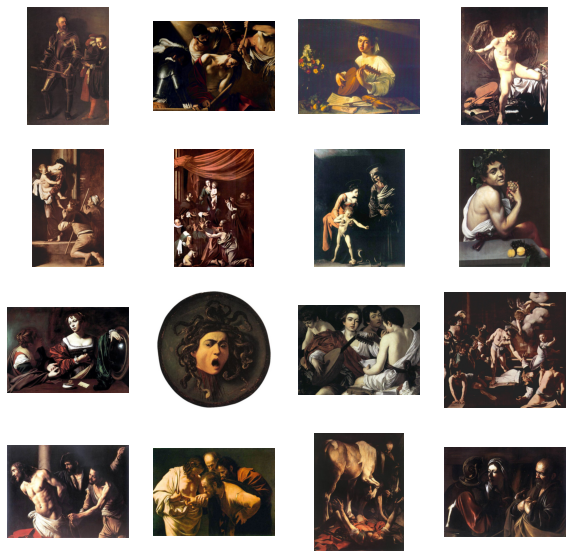

In [7]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))

for ax, img_path in zip(axes.flatten(), train_paths):
    with fs.open(img_path) as f:
        ax.imshow(Image.open(f))
        ax.axis("off")

Although we are using the same dataset and number of training samples, the exact 8000 images that you train your model on may vary (although we are seeding!) because the dataset here has only 20000 images with different ordering while I sampled 10000 images from the complete dataset.

### 1.2- Making Datasets and DataLoaders

I hope the code is self-explanatory. I'm resizing the images and flipping horizontally (flipping only if it is training set) and then I read an RGB image, convert it to Lab color space and separate the first (grayscale) channel and the color channels as my inputs and targets for the models  respectively. Then I'm making the data loaders.

In [8]:
SIZE = 256
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)
        
        self.split = split
        self.size = SIZE
        self.paths = paths
    
    def __getitem__(self, idx):
        with fs.open(self.paths[idx]) as f:
            img = Image.open(f).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1
        
        return {'L': L, 'ab': ab}
    
    def __len__(self):
        return len(self.paths)

def make_dataloaders(batch_size=16, n_workers=4, pin_memory=True, **kwargs): # A handy function to make our dataloaders
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

In [9]:
train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(paths=val_paths, split='val')

data = next(iter(train_dl))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_dl), len(val_dl))

torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
61 16


### 1.3- Generator proposed by the paper

This one is a little complicated and needs explanation. This code implements a U-Net to be used as the generator of our GAN. The details of the code are out of the scope of this article but the important thing to understand is that it makes the U-Net from the middle part of it (down in the U shape) and adds down-sampling and up-sampling modules to the left and right of that middle module (respectively) at every iteration until it reaches the input module and output module. Look at the following image that I made from one of the images in the article to give you a better sense of what is happening in the code:

![unet](https://github.com/moein-shariatnia/Deep-Learning/blob/main/Image%20Colorization%20Tutorial/files/unet.png?raw=1)

The blue rectangles show the order in which the related modules are built with the code. The U-Net we will build has more layers than what is depicted in this image but it suffices to give you the idea. Also notice in the code that we are going 8 layers down, so if we start with a 256 by 256 image, in the middle of the U-Net we will get a 1 by 1 (256 / 2⁸) image and then it gets up-sampled to produce a  256 by 256 image (with two channels). This code snippet is really exciting and I highly recommend to play with it to fully grasp what every line of it is doing.

In [10]:
class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)
        
        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)
    
    def forward(self, x):
        return self.model(x)

### 1.4- Discriminator

The architecture of our discriminator is rather straight forward. This code implements a model by stacking blocks of Conv-BatchNorm-LeackyReLU to decide whether the input image is fake or real. Notice that the first and last blocks do not use normalization and the last block has no activation function (it is embedded in the loss function we will use).

In [16]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) 
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

Let's take a look at its blocks:

In [17]:
PatchDiscriminator(3)

PatchDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (

And its output shape:

In [18]:
discriminator = PatchDiscriminator(3)
dummy_input = torch.randn(16, 3, 256, 256) # batch_size, channels, size, size
out = discriminator(dummy_input)
out.shape

torch.Size([16, 1, 30, 30])

We are using a "Patch" Discriminator here. Okay, what is it?! In a vanilla discriminator, the model outputs one number (a scaler) which represents how much the model thinks the input (which is the whole image) is real (or fake). In a patch discriminator, the model outputs one number for every patch of say 70 by 70 pixels of the input image and for each of them decides whether it is fake or not separately. Using such a model for the task of colorization seems reasonable to me because the local changes that the model needs to make are really important and maybe deciding on the whole image as in vanilla discriminator cannot take care of the subtleties of this task. Here, the model's output shape is 30 by 30 but it does not mean that our patches are 30 by 30. The actual patch size is obtained when you compute the receptive field of each of these 900 (30 multiplied by 30) output numbers which in our case will be 70 by 70.

### 1.5- GAN Loss

This is a handy class we can use to calculate the GAN loss of our final model. In the __init__ we decide which kind of loss we're going to use (which will be "vanilla" in our project) and register some constant tensors as the "real" and "fake" labels. Then when we call this module, it makes an appropriate tensor full of zeros or ones (according to what we need at the stage) and computes the loss.

In [19]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

### 1.x Model Initialization

In the TowardsDataScince article, I didn't explain this function. Here is our logic to initialize our models. We are going to initialize the weights of our model with a mean of 0.0 and standard deviation of 0.02 which are the proposed hyperparameters in the article:

In [20]:
def init_weights(net, init='norm', gain=0.02):
    
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
            
    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

### 1.6- Putting everything together

This class brings together all the previous parts and implements a few methods to take care of training our complete model. Let's investigate it. 

In the __init__ we define our generator and discriminator using the previous functions and classes we defined and we also initialize them with init_model function which I didn't explain here but you can refer to my GitHub repository to see how it works. Then we define our two loss functions and the optimizers of the generator and discriminator. 

The whole work is being done in optimize method of this class. First and only once per iteration (batch of training set) we call the module's forward method and store the outputs in fake_color variable of the class. 

Then, we first train the discriminator by using backward_D method in which we feed the fake images produced by generator to the discriminator (make sure to detach them from the generator's graph so that they act as a constant to the discriminator, like normal images) and label them as fake. Then we feed a batch of real images from training set to the discriminator and label them as real. We add up the two losses for fake and real and take the average and then call the backward on the final loss. 
Now, we can train the generator. In backward_G method we feed the discriminator the fake image and try to fool it by assigning real labels to them and calculating the adversarial loss. As I mentioned earlier, we use L1 loss as well and compute the distance between the predicted two channels and the target two channels and multiply this loss by a coefficient (which is 100 in our case) to balance the two losses and then add this loss to the adversarial loss. Then we call the backward method of the loss.

In [21]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4, 
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        
        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))
    
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)
        
    def forward(self):
        self.fake_color = self.net_G(self.L)
    
    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()
    
    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

### 1.xx Utility functions

These functions were nor included in the explanations of the TDS article. These are just some utility functions to log the losses of our network and also visualize the results during training. So here you can check them out:

In [22]:
class AverageMeter:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3
    
    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    
    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """
    
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)
    
def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"outputs/colorization_{time.time()}.png")
        
def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

### 1.7- Training function

I hope this code is self-explanatory. Every epoch takes about 4 minutes on not a powerful GPU as Nvidia P5000. So if you are using 1080Ti or higher, it will be much faster.

In [39]:
def train_model(model, train_dl, epochs, display_every=200):
    data = next(iter(val_dl)) # getting a batch for visualizing the model output after fixed intrvals
    for e in tqdm(range(epochs)):
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to 
        i = 0                                  # log the losses of the complete network
        for data in train_dl:
            model.setup_input(data) 
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
            i += 1
            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict) # function to print out the losses
                visualize(model, data, save=True) # function displaying the model's outputs

In [ ]:
# model = MainModel()
# train_model(model, train_dl, 40)
# modelVarOne = MainModel(lr_G=3e-4, lr_D=3e-4)
# train_model(modelVarOne, train_dl, 40)
# modelVarTwo = MainModel(lr_G=4e-4, lr_D=4e-4)
# train_model(modelVarTwo, train_dl, 40)
# modelVarThree = MainModel(lambda_L1=150.)
# train_model(modelVarThree, train_dl, 40)
# modelVarFour = MainModel(lr_G=3e-4, lr_D=3e-4, lambda_L1=150.)
# train_model(modelVarFour, train_dl, 40)
# modelVarFive = MainModel(lr_G=4e-4, lr_D=4e-4, lambda_L1=150.)
# train_model(modelVarFive, train_dl, 40)
modelVarSix = MainModel(lambda_L1=75.)
train_model(modelVarSix, train_dl, 40)

model initialized with norm initialization
model initialized with norm initialization


/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


  0%|          | 0/40 [00:00<?, ?it/s]

Every epoch takes about 3 to 4 minutes on Colab. After about 20 epochs you should see some reasonable results.

In [39]:
# with open('40Epoch_Baseline_Correct_ThirdIter_TRAINdl.pickle', 'wb') as f:
#     pickle.dump(train_dl, f)
# with open('40Epoch_Baseline_Correct_ThirdIter_VALdl.pickle', 'wb') as f:
#     pickle.dump(val_dl, f)

In [66]:
# with open('40Epoch_VariationOne_Correct_ThirdIter.pickle', 'wb') as f:
#     pickle.dump(modelVarOne, f)

# with open('40Epoch_Baseline_Correct_FourthIter.pickle', 'wb') as f:
#     pickle.dump(model, f)

# with open('40Epoch_VariationOne_Correct_FourthIter.pickle', 'wb') as f:
#     pickle.dump(modelVarOne, f)

# with open('40Epoch_VariationTwo_Correct_FourthIter.pickle', 'wb') as f:
#     pickle.dump(modelVarTwo, f)

# with open('40Epoch_VariationThree_Correct_FourthIter.pickle', 'wb') as f:
#     pickle.dump(modelVarThree, f)

# with open('40Epoch_VariationFour_Correct_FourthIter.pickle', 'wb') as f:
#     pickle.dump(modelVarFour, f)

In [30]:
# with open('40Epoch_Baseline_Correct_FourthIter.pickle', 'rb') as f:
#     model = pickle.load(f)

# with open('40Epoch_VariationOne_Correct_FourthIter.pickle', 'rb') as f:
#     model = pickle.load(f)

In [350]:
# def save_output(model, data, dst='outputs'):
#     out_arr = []
#     model.net_G.eval()
#     with torch.no_grad():
#         model.setup_input(data)
#         model.forward()
#     model.net_G.train()
#     fake_color = model.fake_color.detach()
# #     real_color = model.ab
#     L = model.L
#     fake_imgs = lab_to_rgb(L, fake_color)
# #     real_imgs = lab_to_rgb(L, real_color)
# #     fig = plt.figure(figsize=(256, 256))
# #     print(fake_imgs[0].shape)
# #     print(fake_imgs[0])
# #     print(type(fake_imgs[0]))
# #     print(fake_imgs[0].shape)
# #     for i in range(len(fake_imgs)):
#     for i in range(1):
#         newimgmine = transform.resize(fake_imgs[i], (224, 224, 3), order=0)
# #         display(newimgmine)
#         print(type(newimgmine))
#         print(newimgmine.shape)
# #         Image.imshow(fake_imgs[0])
#         img1 = Image.fromarray(fake_imgs[i], 'RGB')
#         display(img1)
#         img = Image.fromarray(newimgmine, 'RGB')
#         display(img)
# #         out_arr.append(fake_imgs[i])
#     return out_arr
# #         ax = plt.subplot(3, 5, i + 1)
# #         ax.imshow(L[i][0].cpu(), cmap='gray')
# #         ax.axis("off")
        
# #         ax = plt.subplot(3, 5, i + 1 + 10)
# #         ax.imshow(real_imgs[i])
# #         ax.axis("off")
# #     ax = plt.subplot(3, 5, 0 + 1 + 5)
# #     ax.imshow(fake_imgs[0])
# #     ax.axis("off")
# #     plt.show()
# #     plt.show()
# #         fig.savefig(f"{dst}/colorization_{time.time()}.png")

In [46]:
def save_output(model, data, dst='outputs', bw=False):
    out_arr = []
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    real_imgs = lab_to_rgb(L, real_color)
#     real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
#     real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(256, 256))
    for i in range(len(fake_imgs)):
#         ax = plt.subplot(3, 5, i + 1)
#         ax.imshow(L[i][0].cpu(), cmap='gray')
#         ax.axis("off")


#         ax = plt.subplot(3, 5, i + 1 + 5)
#         ax.imshow(fake_imgs[i])
#         ax.axis("off")

#         ax = plt.subplot(0, 0, 0)
#         plt.imshow(fake_imgs[i])
#         fig.savefig(f"{dst}/colorization_{time.time()}.png")
        
        if bw:
            newimgmine = transform.resize(real_imgs[i], (224, 224, 3), order=0)
            newimgmine = np.dot(newimgmine[...,:3], [0.2989, 0.5870, 0.1140])
            newimgmine = np.expand_dims(newimgmine, 2)
            newimgmine = np.tile(newimgmine, (1,1,3))
        else:
            newimgmine = transform.resize(fake_imgs[i], (224, 224, 3), order=0)
        
#         plt.imshow(newimgmine)
#         print(fake_imgs[i].shape)
#         print(newimgmine.shape)
        out_arr.append(newimgmine)
#     return out_arr
#         ax.axis("off")
        
        
#         ax = plt.subplot(3, 5, i + 1 + 10)
#         ax.imshow(real_imgs[i])
#         ax.axis("off")
#     ax = plt.subplot(3, 5, 0 + 1 + 5)
#     ax.imshow(fake_imgs[0])
#     ax.axis("off")
#     plt.show()
#     plt.show()

    print(len(out_arr))
    return out_arr

In [72]:
# # Generating test data

full_arr = []
for data in tqdm(val_dl):
    out_arr = save_output(modelVarFive, data, 'outputs', bw=False)
    full_arr.extend(out_arr)
print(len(full_arr))

/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p36/lib/python3.6/site-packages/ipykernel/__main__.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/16 [00:00<?, ?it/s]

16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
8
248


<Figure size 18432x18432 with 0 Axes>

<Figure size 18432x18432 with 0 Axes>

<Figure size 18432x18432 with 0 Axes>

<Figure size 18432x18432 with 0 Axes>

<Figure size 18432x18432 with 0 Axes>

<Figure size 18432x18432 with 0 Axes>

<Figure size 18432x18432 with 0 Axes>

<Figure size 18432x18432 with 0 Axes>

<Figure size 18432x18432 with 0 Axes>

<Figure size 18432x18432 with 0 Axes>

<Figure size 18432x18432 with 0 Axes>

<Figure size 18432x18432 with 0 Axes>

<Figure size 18432x18432 with 0 Axes>

<Figure size 18432x18432 with 0 Axes>

<Figure size 18432x18432 with 0 Axes>

<Figure size 18432x18432 with 0 Axes>

In [330]:
def generate_bwimage(model, data, dst='outputs'):
    newout_arr = []
    real_color = model.ab
    L = model.L
    real_imgs = lab_to_rgb(L, real_color)
#     print(real_imgs[0].shape)
#     print(real_imgs[0])
#     print(len(real_imgs))
#     print(real_imgs[0])
    for i in range(1):
        myb = np.dot(real_imgs[i][...,:3], [0.2989, 0.5870, 0.1140])
        myb = np.expand_dims(myb, 2)
        myb = np.tile(myb, (1,1,3))
        plt.imshow(myb)
        newout_arr.append(myb)
    print(len(newout_arr))
    return newout_arr
#     for i in range(16):
#     plt.imshow(real_imgs[3])
#     img = Image.asarray(real_imgs[3]).convert('LA')
#     img = transforms.Grayscale(real_imgs[0]num_output_channels=3)
#     plt.imshow(img)
#     mynewimg = np.dot(real_imgs[0][...,:3], [0.299, 0.587, 0.114])
#     fig = plt.figure(figsize=(224, 224))
#     plt.imshow(mynewimg)
#     mynewimg = np.dot(real_imgs[0][...,:3], [0.114, 0.299, 0.587])
#     fig = plt.figure(figsize=(224, 224))
#     plt.imshow(mynewimg)
#     mynewimg = np.dot(real_imgs[0][...,:3], [0.587, 0.114, 0.299])
#     fig = plt.figure(figsize=(224, 224))
#     plt.imshow(mynewimg)
#     print(type(data))
#     print(data.keys())
#     model.net_G.eval()
#     with torch.no_grad():
#         model.setup_input(data)
#         model.forward()
#     model.net_G.train()
#     fake_color = model.fake_color.detach()
#     L = model.L
#     fake_imgs = lab_to_rgb(L, fake_color)
#     fig = plt.figure(figsize=(256, 256))
#     for i in range(len(fake_imgs)):
#         newimgmine = transform.resize(fake_imgs[i], (224, 224, 3), order=0)
#         out_arr.append(newimgmine)
#     return out_arr

In [73]:
# with open('nparray_VarOne_output.pickle', 'wb') as f:
#     pickle.dump(full_arr, f)

# with open('nparray_VarTwo_output.pickle', 'wb') as f:
#     pickle.dump(full_arr, f)

# with open('nparray_VarThree_output.pickle', 'wb') as f:
#     pickle.dump(full_arr, f)

with open('nparray_VarFive_output.pickle', 'wb') as f:
    pickle.dump(full_arr, f)

In [338]:
# bw_all_arr = []
# print(len(val_dl), "is len")
# for data in val_dl:
# #     print(type(data))
#     fout_arr = generate_bwimage(model, data, 'outputs')
#     bw_all_arr.extend(fout_arr)
#     break
# print(len(bw_all_arr))
# # bw_all_arr = bw_all_arr[:-8]

# # Generating test data

bwfull_arr = []
for data in tqdm(val_dl):
    out_arr = save_output(model, data, 'outputs', True)
    bwfull_arr.extend(out_arr)
print(len(bwfull_arr))

/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p36/lib/python3.6/site-packages/ipykernel/__main__.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/16 [00:00<?, ?it/s]

16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
8
248
Error in callback <function flush_figures at 0x7f62d3373378> (for post_execute):


KeyboardInterrupt: 

In [1]:
plt.imshow(bwfull_arr[1])
print(bwfull_arr[0].shape)

NameError: name 'plt' is not defined

In [344]:
# with open('nparray_Baseline_output_bw.pickle', 'wb') as f:
#     pickle.dump(bwfull_arr, f)

# with open('nparray_Baseline_output_v2.pickle', 'wb') as f:
#     pickle.dump(full_arr, f)

In [2]:
# with open("3rdClassifierModel_3Frozen.pickle", "rb") as input_file:
#      custom_vgg_model2 = pickle.load(input_file)

NameError: name 'pickle' is not defined

In [44]:
print(merged_train_images)

['Michelangelo_45.jpg', 'Michelangelo_44.jpg', 'Michelangelo_46.jpg', 'Michelangelo_47.jpg', 'Michelangelo_43.jpg', 'Michelangelo_42.jpg', 'Michelangelo_40.jpg', 'Michelangelo_9.jpg', 'Michelangelo_8.jpg', 'Michelangelo_41.jpg', 'Michelangelo_26.jpg', 'Michelangelo_32.jpg', 'Michelangelo_33.jpg', 'Michelangelo_27.jpg', 'Michelangelo_19.jpg', 'Michelangelo_31.jpg', 'Michelangelo_25.jpg', 'Michelangelo_24.jpg', 'Michelangelo_30.jpg', 'Michelangelo_18.jpg', 'Michelangelo_34.jpg', 'Michelangelo_20.jpg', 'Michelangelo_21.jpg', 'Michelangelo_35.jpg', 'Michelangelo_23.jpg', 'Michelangelo_37.jpg', 'Michelangelo_36.jpg', 'Michelangelo_22.jpg', 'Michelangelo_13.jpg', 'Michelangelo_12.jpg', 'Michelangelo_38.jpg', 'Michelangelo_10.jpg', 'Michelangelo_11.jpg', 'Michelangelo_39.jpg', 'Michelangelo_15.jpg', 'Michelangelo_29.jpg', 'Michelangelo_28.jpg', 'Michelangelo_14.jpg', 'Michelangelo_16.jpg', 'Titian_232.jpg', 'Titian_226.jpg', 'Titian_144.jpg', 'Titian_91.jpg', 'Titian_85.jpg', 'Titian_150.jpg'

In [63]:
print([newdir[myidx] for myidx in newvalidxs])

['s3://sagemaker-studio-sqsv4ommlw8/resized/Caravaggio_10.jpg', 's3://sagemaker-studio-sqsv4ommlw8/resized/Caravaggio_11.jpg', 's3://sagemaker-studio-sqsv4ommlw8/resized/Caravaggio_12.jpg', 's3://sagemaker-studio-sqsv4ommlw8/resized/Caravaggio_13.jpg', 's3://sagemaker-studio-sqsv4ommlw8/resized/Caravaggio_14.jpg', 's3://sagemaker-studio-sqsv4ommlw8/resized/Caravaggio_15.jpg', 's3://sagemaker-studio-sqsv4ommlw8/resized/Caravaggio_16.jpg', 's3://sagemaker-studio-sqsv4ommlw8/resized/Caravaggio_17.jpg', 's3://sagemaker-studio-sqsv4ommlw8/resized/Caravaggio_28.jpg', 's3://sagemaker-studio-sqsv4ommlw8/resized/Caravaggio_29.jpg', 's3://sagemaker-studio-sqsv4ommlw8/resized/Caravaggio_38.jpg', 's3://sagemaker-studio-sqsv4ommlw8/resized/Caravaggio_39.jpg', 's3://sagemaker-studio-sqsv4ommlw8/resized/El_Greco_4.jpg', 's3://sagemaker-studio-sqsv4ommlw8/resized/El_Greco_40.jpg', 's3://sagemaker-studio-sqsv4ommlw8/resized/El_Greco_41.jpg', 's3://sagemaker-studio-sqsv4ommlw8/resized/El_Greco_42.jpg', 

In [70]:
print(newdir[1].split('/')[4].split('.')[0].rpartition('_')[0])
print(newdir[55].split('/')[4].split('.')[0].rpartition('_')[0])

Caravaggio
El_Greco


In [73]:
artistDict = {'Caravaggio': 0,
              'El_Greco': 1,
              'Eugene_Delacroix': 2,
              'Gustave_Courbet': 3,
              'Michelangelo': 4,
              'Peter_Paul_Rubens': 5,
              'Raphael': 6,
              'Rembrandt': 7,
              'Sandro_Botticelli': 8,
              'Titian': 9
}


print([artistDict[newdir[myidx].split('/')[4].split('.')[0].rpartition('_')[0]] for myidx in newvalidxs])
# Caravaggio 0 55
# El_Greco 55 142
# Eugene_Delacroix 142 173
# Gustave_Courbet 173 232
# Michelangelo 232 281
# Peter_Paul_Rubens 281 422
# Raphael 422 531
# Rembrandt 531 793
# Sandro_Botticelli 793 957
# Titian 957 1211

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]


In [49]:
def our_rmse(model, data):
    out_arr = []
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    real_imgs = lab_to_rgb(L, real_color)
#     real_color = model.ab
    fake_imgs = lab_to_rgb(L, fake_color)
#     real_imgs = lab_to_rgb(L, real_color)
#     fig = plt.figure(figsize=(256, 256))
    for i in range(len(fake_imgs)):
#         ax = plt.subplot(3, 5, i + 1)
#         ax.imshow(L[i][0].cpu(), cmap='gray')
#         ax.axis("off")


#         ax = plt.subplot(3, 5, i + 1 + 5)
#         ax.imshow(fake_imgs[i])
#         ax.axis("off")

#         ax = plt.subplot(0, 0, 0)
#         plt.imshow(fake_imgs[i])
        
#         if bw:
        resized_real = transform.resize(real_imgs[i], (224, 224, 3), order=0)
#         else:
        resized_fake = transform.resize(fake_imgs[i], (224, 224, 3), order=0)
    
#         print(np.sqrt(np.mean((resized_fake-resized_real)**2)))
        out_arr.append(np.sqrt(np.mean((resized_fake-resized_real)**2)))
        
#         plt.imshow(newimgmine)
#         print(fake_imgs[i].shape)
#         print(newimgmine.shape)
#         out_arr.append(newimgmine)
#     return out_arr
#         ax.axis("off")
        
        
#         ax = plt.subplot(3, 5, i + 1 + 10)
#         ax.imshow(real_imgs[i])
#         ax.axis("off")
#     ax = plt.subplot(3, 5, 0 + 1 + 5)
#     ax.imshow(fake_imgs[0])
#     ax.axis("off")
#     plt.show()
#     plt.show()
#         fig.savefig(f"{dst}/colorization_{time.time()}.png")
#     print(len(out_arr))
    return out_arr

In [74]:
all_rmse_arr = []
for data in tqdm(val_dl):
    out_arr = our_rmse(modelVarFive, data)
    all_rmse_arr.extend(out_arr)
print(len(all_rmse_arr))
print(sum(all_rmse_arr)/len(all_rmse_arr))

/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/16 [00:00<?, ?it/s]

248
0.05883950677419883
